In [1]:
SEED = 123

import numpy as np
np.random.seed(SEED)

import pandas as pd
pd.options.display.max_rows = 10

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = "retina"

from tqdm.auto import tqdm

In [2]:
%%time

transactions_dtype = dict(top_1_category_1="category",
                          top_1_category_2="category",
                          top_1_category_3="category",
                          top_1_installments="category")

base_historical_transactions_df = pd.read_csv("data/output/base_historical_transactions.csv",
                                              dtype=transactions_dtype)

assert base_historical_transactions_df.isnull().any().any() == False

display(base_historical_transactions_df)

,card_id,pct_of_authorized_transactions,pct_of_category_1_1,top_1_category_1,pct_of_category_2_missing,pct_of_category_2_1,pct_of_category_2_2,pct_of_category_2_3,pct_of_category_2_4,pct_of_category_2_5,...,pct_of_installments_999,top_1_installments,top_1_city_id,min_purchase_amount,avg_purchase_amount,max_purchase_amount,sum_purchase_amount,top_1_purchase_amount,top_1_state_id,top_1_subsector_id
0,C_ID_00007093c1,0.765101,0.187919,0,0.187919,0.000000,0.000000,0.805369,0.000000,0.006711,...,0.0,1,244,-0.728876,-0.515739,1.507069,-76.845041,-0.721363,2,19
1,C_ID_0001238066,0.975610,0.016260,0,0.065041,0.772358,0.000000,0.000000,0.000000,0.162602,...,0.0,1,314,-0.734887,-0.589002,0.768095,-72.447201,-0.596643,9,19
2,C_ID_0001506ef0,0.939394,0.000000,0,0.000000,0.030303,0.000000,0.969697,0.000000,0.000000,...,0.0,0,137,-0.740491,-0.524271,1.493545,-34.601879,-0.724368,19,33
3,C_ID_0001793786,0.875000,0.009259,0,0.527778,0.050926,0.351852,0.069444,0.000000,0.000000,...,0.0,0,179,-0.745405,-0.170306,4.554145,-36.786013,-0.566620,-1,37
4,C_ID_000183fdda,0.951389,0.027778,0,0.027778,0.048611,0.006944,0.909722,0.000000,0.006944,...,0.0,1,161,-0.737892,-0.478041,2.764788,-68.837938,-0.671775,3,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325535,C_ID_ffff1d9928,0.750000,0.166667,0,0.166667,0.083333,0.000000,0.000000,0.750000,0.000000,...,0.0,1,114,-0.746893,-0.623139,0.004418,-7.477673,-0.742415,4,33
325536,C_ID_ffff579d3a,0.868421,0.000000,0,0.000000,0.991228,0.000000,0.000000,0.000000,0.008772,...,0.0,0,70,-0.739244,-0.704323,-0.491457,-80.292768,-0.716855,9,37
325537,C_ID_ffff756266,0.583333,0.125000,0,0.125000,0.875000,0.000000,0.000000,0.000000,0.000000,...,0.0,1,233,-0.746156,-0.229434,1.206403,-5.506420,-0.596643,9,20
325538,C_ID_ffff828181,0.873684,0.057895,0,0.057895,0.094737,0.805263,0.000000,0.036842,0.005263,...,0.0,1,96,-0.745405,-0.632101,0.109528,-120.099200,-0.671775,24,19


CPU times: user 3.33 s, sys: 112 ms, total: 3.45 s
Wall time: 2.75 s


In [3]:
%%time

purchase_amount_historical_transactions_df = pd.read_csv("data/output/purchase_amount_historical_transactions.csv")

assert purchase_amount_historical_transactions_df.isnull().any().any() == False

display(purchase_amount_historical_transactions_df)

,card_id,purchase_amount_last_1_month,purchase_amount_last_3_months,purchase_amount_last_6_months,purchase_amount_last_1_year
0,C_ID_00007093c1,-6.250338,-17.916185,-34.354092,-75.510626
1,C_ID_0001238066,-14.894008,-49.918778,-72.447201,-72.447201
2,C_ID_0001506ef0,-2.046776,-16.294779,-21.094548,-29.727369
3,C_ID_0001793786,0.000000,0.000000,-11.436843,-38.347778
4,C_ID_000183fdda,-15.638962,-36.158957,-68.611098,-68.837938
...,...,...,...,...,...
325535,C_ID_ffff1d9928,0.000000,-4.860220,-7.477673,-7.477673
325536,C_ID_ffff579d3a,-4.777108,-26.492702,-64.671372,-80.292768
325537,C_ID_ffff756266,0.000000,0.000000,-5.120374,-4.342316
325538,C_ID_ffff828181,-5.655453,-31.504239,-61.530996,-105.611840


CPU times: user 407 ms, sys: 11.8 ms, total: 418 ms
Wall time: 305 ms


In [4]:
data_dtype = dict(feature_1="category",
                  feature_2="category",
                  feature_3="category")

train_df = pd.read_csv("data/input/train.csv", dtype=data_dtype, parse_dates=["first_active_month"])
test_df  = pd.read_csv("data/input/test.csv",  dtype=data_dtype, parse_dates=["first_active_month"])

train_test_first_active_month = pd.concat([train_df.first_active_month, test_df.first_active_month])
test_df.first_active_month.fillna(train_test_first_active_month.value_counts().index[0], inplace=True)

train_df = train_df.merge(base_historical_transactions_df,            how="left", on="card_id") \
                   .merge(purchase_amount_historical_transactions_df, how="left", on="card_id")

test_df  = test_df.merge(base_historical_transactions_df,            how="left", on="card_id") \
                  .merge(purchase_amount_historical_transactions_df, how="left", on="card_id")

assert train_df.isnull().any().any() == False
assert  test_df.isnull().any().any() == False

display(train_df, test_df)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,pct_of_authorized_transactions,pct_of_category_1_1,top_1_category_1,pct_of_category_2_missing,...,avg_purchase_amount,max_purchase_amount,sum_purchase_amount,top_1_purchase_amount,top_1_state_id,top_1_subsector_id,purchase_amount_last_1_month,purchase_amount_last_3_months,purchase_amount_last_6_months,purchase_amount_last_1_year
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,0.950000,0.000000,0,0.000000,...,-0.638341,2.258395,-165.968739,-0.724368,9,34,-15.549885,-59.377186,-100.088244,-165.968739
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,0.968571,0.088571,0,0.088571,...,-0.600018,4.630299,-210.006336,-0.733384,9,34,0.000000,-66.771748,-102.981569,-190.129717
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,0.953488,0.000000,0,0.000000,...,-0.678311,-0.145847,-29.167391,-0.701453,5,33,-0.661287,-2.202346,-6.989342,-20.896063
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,1.000000,0.155844,0,0.155844,...,-0.642745,1.445596,-49.491364,-0.737892,22,37,-10.755511,-18.492046,-49.491364,-49.491364
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,0.962406,0.112782,0,0.112782,...,-0.366073,7.193041,-48.687656,-0.507986,22,37,9.955365,-38.813225,-48.687656,-48.687656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201912,2017-09-01,C_ID_963962de2c,3,2,1,-2.740821,0.913043,0.000000,0,0.000000,...,-0.709244,-0.571909,-32.625247,-0.679288,7,33,-7.042325,-19.852396,-32.625247,-32.625247
201913,2015-10-01,C_ID_1314773c0b,3,1,1,0.312917,0.851064,0.000000,0,0.000000,...,-0.711339,-0.574253,-33.432922,-0.739395,15,37,-4.279115,-13.058399,-23.838073,-32.704046
201914,2017-08-01,C_ID_7666735b3d,4,3,0,0.093494,0.931034,0.091954,0,0.183908,...,-0.381465,6.015023,-33.187479,-0.596643,8,16,0.267201,3.058045,-32.699478,-33.187479
201915,2016-07-01,C_ID_73f5a0efd0,3,2,1,-4.676589,0.923077,0.000000,0,0.000000,...,-0.688037,-0.609520,-17.888957,-0.731881,9,1,0.000000,0.000000,-6.843404,-15.797056


,first_active_month,card_id,feature_1,feature_2,feature_3,pct_of_authorized_transactions,pct_of_category_1_1,top_1_category_1,pct_of_category_2_missing,pct_of_category_2_1,...,avg_purchase_amount,max_purchase_amount,sum_purchase_amount,top_1_purchase_amount,top_1_state_id,top_1_subsector_id,purchase_amount_last_1_month,purchase_amount_last_3_months,purchase_amount_last_6_months,purchase_amount_last_1_year
0,2017-04-01,C_ID_0ab67a22ab,3,3,1,0.647059,0.338235,0,0.338235,0.661765,...,-0.599025,0.235676,-40.733733,-0.716855,12,29,0.000000,-6.317461,-22.171844,-40.733733
1,2017-01-01,C_ID_130fd0cbdd,2,3,0,0.987179,0.025641,0,0.025641,0.000000,...,-0.629955,0.318818,-49.136513,-0.701828,13,33,-1.272926,-1.272926,-1.272926,-34.889772
2,2017-08-01,C_ID_b709037bc5,5,1,1,0.692308,0.076923,0,0.076923,0.076923,...,0.348372,2.525866,4.528840,-0.536537,5,27,1.785255,5.875772,5.050711,4.528840
3,2017-12-01,C_ID_d27d835a9f,2,1,0,1.000000,0.000000,0,0.000000,1.000000,...,-0.526566,0.087965,-13.690715,-0.731881,9,27,-5.834118,-13.690715,-13.690715,-13.690715
4,2015-12-01,C_ID_2b5e3df5c2,5,1,1,0.790909,0.000000,0,0.000000,0.036364,...,0.228540,15.782255,25.139384,-0.701828,13,33,-9.172348,8.973307,38.148617,17.525210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123618,2017-10-01,C_ID_7a239d2eda,2,2,0,0.958904,0.000000,0,0.958904,0.041096,...,-0.676778,-0.525387,-49.404782,-0.705870,-1,16,-12.334527,-34.671738,-49.404782,-49.404782
123619,2017-09-01,C_ID_75ace375ae,3,1,1,1.000000,0.000000,0,0.000000,0.857143,...,-0.702088,-0.578911,-4.914616,-0.736404,9,33,0.000000,-2.873640,-4.914616,-4.914616
123620,2016-09-01,C_ID_21d56d950c,5,1,1,0.972973,0.081081,0,0.081081,0.027027,...,-0.177938,1.664306,-6.583716,-0.422636,5,33,-1.133134,-2.227064,-2.720986,-6.583716
123621,2017-06-01,C_ID_6c46fc5a9d,2,1,0,0.693548,0.000000,0,0.000000,0.064516,...,-0.631026,-0.115794,-39.123627,-0.622233,7,27,0.000000,0.000000,-16.099675,-39.123627


In [5]:
for df in [train_df, test_df]:
    days_diff = train_df.first_active_month.max() - df.first_active_month
    df["years_since_first_active"]  = (days_diff / np.timedelta64(1, "Y")).astype(int)
    df["months_since_first_active"] = (days_diff / np.timedelta64(1, "M")).astype(int)
    
display(train_df, test_df)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,pct_of_authorized_transactions,pct_of_category_1_1,top_1_category_1,pct_of_category_2_missing,...,sum_purchase_amount,top_1_purchase_amount,top_1_state_id,top_1_subsector_id,purchase_amount_last_1_month,purchase_amount_last_3_months,purchase_amount_last_6_months,purchase_amount_last_1_year,years_since_first_active,months_since_first_active
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,0.950000,0.000000,0,0.000000,...,-165.968739,-0.724368,9,34,-15.549885,-59.377186,-100.088244,-165.968739,0,8
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,0.968571,0.088571,0,0.088571,...,-210.006336,-0.733384,9,34,0.000000,-66.771748,-102.981569,-190.129717,1,13
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,0.953488,0.000000,0,0.000000,...,-29.167391,-0.701453,5,33,-0.661287,-2.202346,-6.989342,-20.896063,1,18
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,1.000000,0.155844,0,0.155844,...,-49.491364,-0.737892,22,37,-10.755511,-18.492046,-49.491364,-49.491364,0,5
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,0.962406,0.112782,0,0.112782,...,-48.687656,-0.507986,22,37,9.955365,-38.813225,-48.687656,-48.687656,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201912,2017-09-01,C_ID_963962de2c,3,2,1,-2.740821,0.913043,0.000000,0,0.000000,...,-32.625247,-0.679288,7,33,-7.042325,-19.852396,-32.625247,-32.625247,0,5
201913,2015-10-01,C_ID_1314773c0b,3,1,1,0.312917,0.851064,0.000000,0,0.000000,...,-33.432922,-0.739395,15,37,-4.279115,-13.058399,-23.838073,-32.704046,2,28
201914,2017-08-01,C_ID_7666735b3d,4,3,0,0.093494,0.931034,0.091954,0,0.183908,...,-33.187479,-0.596643,8,16,0.267201,3.058045,-32.699478,-33.187479,0,6
201915,2016-07-01,C_ID_73f5a0efd0,3,2,1,-4.676589,0.923077,0.000000,0,0.000000,...,-17.888957,-0.731881,9,1,0.000000,0.000000,-6.843404,-15.797056,1,19


,first_active_month,card_id,feature_1,feature_2,feature_3,pct_of_authorized_transactions,pct_of_category_1_1,top_1_category_1,pct_of_category_2_missing,pct_of_category_2_1,...,sum_purchase_amount,top_1_purchase_amount,top_1_state_id,top_1_subsector_id,purchase_amount_last_1_month,purchase_amount_last_3_months,purchase_amount_last_6_months,purchase_amount_last_1_year,years_since_first_active,months_since_first_active
0,2017-04-01,C_ID_0ab67a22ab,3,3,1,0.647059,0.338235,0,0.338235,0.661765,...,-40.733733,-0.716855,12,29,0.000000,-6.317461,-22.171844,-40.733733,0,10
1,2017-01-01,C_ID_130fd0cbdd,2,3,0,0.987179,0.025641,0,0.025641,0.000000,...,-49.136513,-0.701828,13,33,-1.272926,-1.272926,-1.272926,-34.889772,1,13
2,2017-08-01,C_ID_b709037bc5,5,1,1,0.692308,0.076923,0,0.076923,0.076923,...,4.528840,-0.536537,5,27,1.785255,5.875772,5.050711,4.528840,0,6
3,2017-12-01,C_ID_d27d835a9f,2,1,0,1.000000,0.000000,0,0.000000,1.000000,...,-13.690715,-0.731881,9,27,-5.834118,-13.690715,-13.690715,-13.690715,0,2
4,2015-12-01,C_ID_2b5e3df5c2,5,1,1,0.790909,0.000000,0,0.000000,0.036364,...,25.139384,-0.701828,13,33,-9.172348,8.973307,38.148617,17.525210,2,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123618,2017-10-01,C_ID_7a239d2eda,2,2,0,0.958904,0.000000,0,0.958904,0.041096,...,-49.404782,-0.705870,-1,16,-12.334527,-34.671738,-49.404782,-49.404782,0,4
123619,2017-09-01,C_ID_75ace375ae,3,1,1,1.000000,0.000000,0,0.000000,0.857143,...,-4.914616,-0.736404,9,33,0.000000,-2.873640,-4.914616,-4.914616,0,5
123620,2016-09-01,C_ID_21d56d950c,5,1,1,0.972973,0.081081,0,0.081081,0.027027,...,-6.583716,-0.422636,5,33,-1.133134,-2.227064,-2.720986,-6.583716,1,17
123621,2017-06-01,C_ID_6c46fc5a9d,2,1,0,0.693548,0.000000,0,0.000000,0.064516,...,-39.123627,-0.622233,7,27,0.000000,0.000000,-16.099675,-39.123627,0,8


In [6]:
class AddYearAndMonthTransformer:
    def call(self, df):
        for attr in ["year", "month"]:
            df["first_active_month" + "_" + attr] = getattr(df.first_active_month.dt, attr)

        return df.drop("first_active_month", axis=1)
    
add_year_and_month_transformer = AddYearAndMonthTransformer()

train_df = add_year_and_month_transformer.call(train_df)
test_df  = add_year_and_month_transformer.call(test_df)

display(train_df, test_df)

,card_id,feature_1,feature_2,feature_3,target,pct_of_authorized_transactions,pct_of_category_1_1,top_1_category_1,pct_of_category_2_missing,pct_of_category_2_1,...,top_1_state_id,top_1_subsector_id,purchase_amount_last_1_month,purchase_amount_last_3_months,purchase_amount_last_6_months,purchase_amount_last_1_year,years_since_first_active,months_since_first_active,first_active_month_year,first_active_month_month
0,C_ID_92a2005557,5,2,1,-0.820283,0.950000,0.000000,0,0.000000,0.988462,...,9,34,-15.549885,-59.377186,-100.088244,-165.968739,0,8,2017,6
1,C_ID_3d0044924f,4,1,0,0.392913,0.968571,0.088571,0,0.088571,0.911429,...,9,34,0.000000,-66.771748,-102.981569,-190.129717,1,13,2017,1
2,C_ID_d639edf6cd,2,2,0,0.688056,0.953488,0.000000,0,0.000000,0.093023,...,5,33,-0.661287,-2.202346,-6.989342,-20.896063,1,18,2016,8
3,C_ID_186d6a6901,4,3,0,0.142495,1.000000,0.155844,0,0.155844,0.155844,...,22,37,-10.755511,-18.492046,-49.491364,-49.491364,0,5,2017,9
4,C_ID_cdbd2c0db2,1,3,0,-0.159749,0.962406,0.112782,0,0.112782,0.075188,...,22,37,9.955365,-38.813225,-48.687656,-48.687656,0,3,2017,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201912,C_ID_963962de2c,3,2,1,-2.740821,0.913043,0.000000,0,0.000000,0.304348,...,7,33,-7.042325,-19.852396,-32.625247,-32.625247,0,5,2017,9
201913,C_ID_1314773c0b,3,1,1,0.312917,0.851064,0.000000,0,0.000000,1.000000,...,15,37,-4.279115,-13.058399,-23.838073,-32.704046,2,28,2015,10
201914,C_ID_7666735b3d,4,3,0,0.093494,0.931034,0.091954,0,0.183908,0.057471,...,8,16,0.267201,3.058045,-32.699478,-33.187479,0,6,2017,8
201915,C_ID_73f5a0efd0,3,2,1,-4.676589,0.923077,0.000000,0,0.000000,1.000000,...,9,1,0.000000,0.000000,-6.843404,-15.797056,1,19,2016,7


,card_id,feature_1,feature_2,feature_3,pct_of_authorized_transactions,pct_of_category_1_1,top_1_category_1,pct_of_category_2_missing,pct_of_category_2_1,pct_of_category_2_2,...,top_1_state_id,top_1_subsector_id,purchase_amount_last_1_month,purchase_amount_last_3_months,purchase_amount_last_6_months,purchase_amount_last_1_year,years_since_first_active,months_since_first_active,first_active_month_year,first_active_month_month
0,C_ID_0ab67a22ab,3,3,1,0.647059,0.338235,0,0.338235,0.661765,0.0,...,12,29,0.000000,-6.317461,-22.171844,-40.733733,0,10,2017,4
1,C_ID_130fd0cbdd,2,3,0,0.987179,0.025641,0,0.025641,0.000000,0.0,...,13,33,-1.272926,-1.272926,-1.272926,-34.889772,1,13,2017,1
2,C_ID_b709037bc5,5,1,1,0.692308,0.076923,0,0.076923,0.076923,0.0,...,5,27,1.785255,5.875772,5.050711,4.528840,0,6,2017,8
3,C_ID_d27d835a9f,2,1,0,1.000000,0.000000,0,0.000000,1.000000,0.0,...,9,27,-5.834118,-13.690715,-13.690715,-13.690715,0,2,2017,12
4,C_ID_2b5e3df5c2,5,1,1,0.790909,0.000000,0,0.000000,0.036364,0.0,...,13,33,-9.172348,8.973307,38.148617,17.525210,2,26,2015,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123618,C_ID_7a239d2eda,2,2,0,0.958904,0.000000,0,0.958904,0.041096,0.0,...,-1,16,-12.334527,-34.671738,-49.404782,-49.404782,0,4,2017,10
123619,C_ID_75ace375ae,3,1,1,1.000000,0.000000,0,0.000000,0.857143,0.0,...,9,33,0.000000,-2.873640,-4.914616,-4.914616,0,5,2017,9
123620,C_ID_21d56d950c,5,1,1,0.972973,0.081081,0,0.081081,0.027027,0.0,...,5,33,-1.133134,-2.227064,-2.720986,-6.583716,1,17,2016,9
123621,C_ID_6c46fc5a9d,2,1,0,0.693548,0.000000,0,0.000000,0.064516,0.0,...,7,27,0.000000,0.000000,-16.099675,-39.123627,0,8,2017,6


In [7]:
X_train, y_train = train_df.drop(["card_id", "target"], axis=1), train_df.target

X_test = test_df.drop("card_id", axis=1)

In [8]:
%%time

model = RandomForestRegressor(n_estimators=100, max_features="sqrt", max_depth=10, n_jobs=-1, random_state=SEED)
scores = np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=10))
print("CV: %.4f +/- %.4f" % (scores.mean(), scores.std() ** 2))

CV: 3.7786 +/- 0.0052
CPU times: user 9.32 s, sys: 1.27 s, total: 10.6 s
Wall time: 1min 17s


In [9]:
%%time

model.fit(X_train, y_train)

CPU times: user 59.4 s, sys: 103 ms, total: 59.5 s
Wall time: 8.15 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=123, verbose=0, warm_start=False)

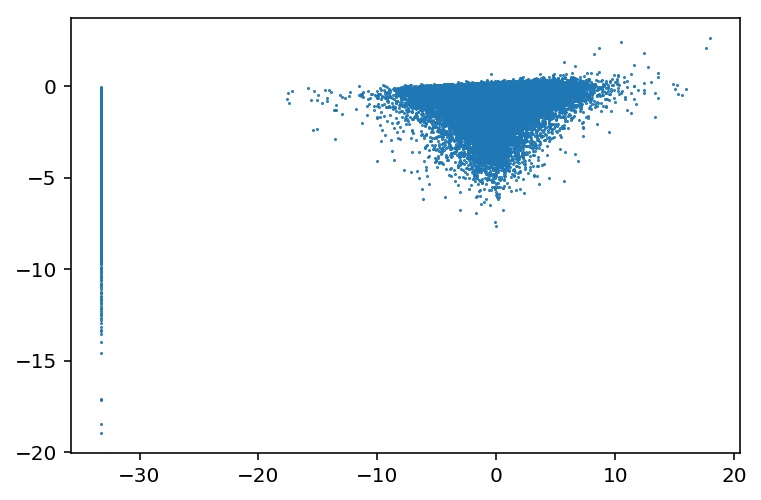

In [10]:
plt.scatter(y_train, model.predict(X_train), s=0.25);

In [11]:
%%time

y_test = model.predict(X_test)

CPU times: user 1.66 s, sys: 55.6 ms, total: 1.72 s
Wall time: 511 ms


In [12]:
submission_df = pd.read_csv("data/input/sample_submission.csv")
submission_df.target = y_test
submission_df.head()

,card_id,target
0,C_ID_0ab67a22ab,-3.286350
1,C_ID_130fd0cbdd,-0.459921
2,C_ID_b709037bc5,-0.173629
3,C_ID_d27d835a9f,0.014130
4,C_ID_2b5e3df5c2,-0.389546


In [13]:
submission_df.isnull().any().any()

False

In [14]:
submission_df.to_csv("submission.csv", index=False)

In [15]:
!head submission.csv

card_id,target
C_ID_0ab67a22ab,-3.2863500222815634
C_ID_130fd0cbdd,-0.4599208602935257
C_ID_b709037bc5,-0.17362872784869143
C_ID_d27d835a9f,0.014129540396692519
C_ID_2b5e3df5c2,-0.38954554283171305
C_ID_5814b4f13c,0.008493707342891892
C_ID_a1b3c75277,-0.007413565069615627
C_ID_f7cada36d3,-0.3032198546483176
C_ID_9d2bc8dfc4,-0.024688552349879926


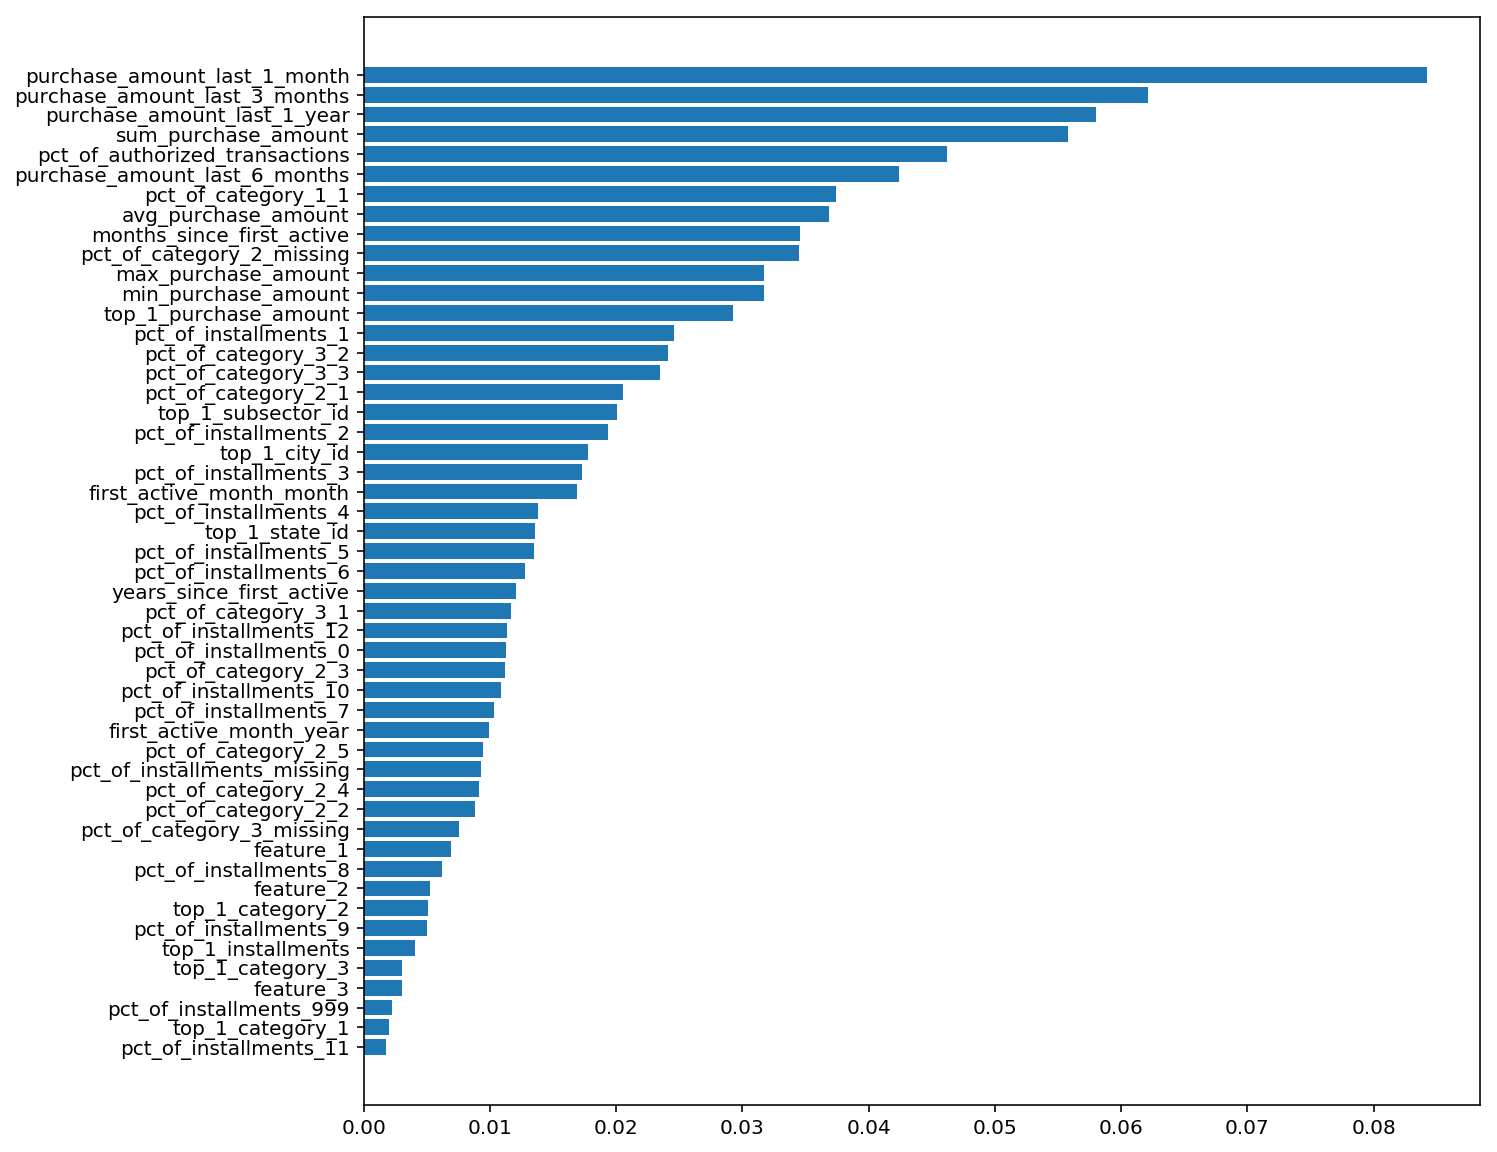

In [16]:
idx = np.argsort(model.feature_importances_)

importances = model.feature_importances_[idx]
columns = X_train.columns.values[idx]

plt.figure(figsize=(10, 10))
plt.barh(columns, importances);